In [26]:
import numpy as np
import pandas as pd

import os
from typing import List, Tuple, Union


import scipy.io
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

[autoreload of pandas._libs.tslibs failed: Traceback (most recent call last):
  File "/Users/jack/Documents/python_venv/crnn/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/jack/Documents/python_venv/crnn/lib/python3.12/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/usr/local/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/importlib/__init__.py", line 131, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 866, in _exec
  File "<frozen importlib._bootstrap_external>", line 995, in exec_module
  File "<frozen importlib._bootstrap>", line 488, in _call_with_frames_removed
  File "/Users/jack/Documents/python_venv/crnn/lib/python3.12/site-packages/pandas/_libs/tslibs/__init__.py", line 38, in <module>
    from pandas._libs.tslibs.dt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import itertools
experiment_folder_name = ['P-4-joint','P-8-joint','P-16-joint','P-32-joint','P-64-joint','P-128-joint']
model_names = ['tanh','dzn', 'dznGen', 'lstm', 'rnn']

for a,b, in itertools.product(experiment_folder_name,model_names):
    print(a,b)

P-4-joint tanh
P-4-joint dzn
P-4-joint dznGen
P-4-joint lstm
P-4-joint rnn
P-8-joint tanh
P-8-joint dzn
P-8-joint dznGen
P-8-joint lstm
P-8-joint rnn
P-16-joint tanh
P-16-joint dzn
P-16-joint dznGen
P-16-joint lstm
P-16-joint rnn
P-32-joint tanh
P-32-joint dzn
P-32-joint dznGen
P-32-joint lstm
P-32-joint rnn
P-64-joint tanh
P-64-joint dzn
P-64-joint dznGen
P-64-joint lstm
P-64-joint rnn
P-128-joint tanh
P-128-joint dzn
P-128-joint dznGen
P-128-joint lstm
P-128-joint rnn


In [21]:
import json
import re
import itertools

# result_folder ='/Users/jack/actuated_pendulum/2024_11_11-results'
result_folder = '/Users/jack/cloud_privat/03_Promotion/_transfer'
embedding_dir = os.path.join(result_folder, '_for_embedding')

experiment_folder_names = ['P-4-joint','P-8-joint','P-16-joint','P-32-joint','P-64-joint','P-128-joint']
model_names = ['tanh','dzn', 'dznGen', 'lstm', 'rnn']

os.makedirs(embedding_dir, exist_ok=True)
# Filter out the embedding directory from the list of subfolders



def get_subfolders_from_experiment_model_name(folder_path: str, experiment_folder_names: str, model_names: List) -> List:
    return [os.path.join(folder_path,f'{experiment_folder_name}-{model_name}') for model_name, experiment_folder_name in itertools.product(model_names,experiment_folder_names)]

def get_subfolders(folder_path: str) -> List:
    return [f.path for f in os.scandir(folder_path) if f.is_dir()]

# model_folders = get_subfolders(result_folder)
# model_folders = [folder for folder in model_folders if ((folder != embedding_dir))]
model_folders = get_subfolders_from_experiment_model_name(result_folder,experiment_folder_name, model_names)

def read_evaluation(folder:str) -> Tuple[float, int, float, float]:
    evaluation_file = os.path.join(folder, 'test-eval.json')
    if os.path.isfile(evaluation_file):
        with open(evaluation_file, 'r') as file:
            evaluation_data = json.load(file)

        return evaluation_data['metrics']['rmse'], evaluation_data['num_parameters'], evaluation_data['additional_tests']['stability_evaluation']['value'],evaluation_data['additional_tests']['stability_l2']['value'] 
    return None, None, None, None

def check_validation_log(folder: str) -> Tuple[float, int, float]:
    log_file = os.path.join(folder, 'validation.log')
    if os.path.isfile(log_file):
        with open(log_file, 'r') as file:
            lines = file.readlines()
            rmse = None
            num_params = None
            l2_gain = None
            for line in lines:
                if 'rmse:' in line:
                    rmse = float(line.split('rmse:')[1].strip())
                if 'Number of parameters:' in line:
                    num_params = int(line.split('Number of parameters:')[1].strip())
                if 'l2 gain:' in line:
                    l2_gain = float(line.split('l2 gain:')[1].strip())
            return rmse, num_params, l2_gain
    return None, None, None




results = [check_validation_log(folder) for folder in model_folders]
results = [read_evaluation(folder) for folder in model_folders]
# Create a DataFrame from the results
df_results = pd.DataFrame({
    'Model': [os.path.basename(folder) for folder in model_folders],
    'RMSE': [result[0] for result in results],
    r'num par': [result[1] for result in results],
    'emp stab': [result[2] for result in results],
    'emp l2': [result[3] for result in results]
})

def extract_stop_duration(folder: str) -> str:
    log_file = os.path.join(folder, 'training.log')
    if os.path.isfile(log_file):
        with open(log_file, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if 'Stop duration:' in line:
                    return line.split('Stop duration:')[1].split('---')[0].strip()
    return None

# Format the 'num par' as integers and round 'RMSE' to two decimal places
df_results['num par'] = df_results['num par'].fillna(0).astype(int)
df_results['RMSE'] = df_results['RMSE'].round(2)

durations = [extract_stop_duration(folder) for folder in model_folders]
df_results['Training Duration'] = durations

def extract_config_info(folder: str) -> Tuple[int, int, int, str]:
    config_file_pattern = re.compile(r'config-experiment-\w+\.json')
    
    for file_name in os.listdir(folder):
        if config_file_pattern.match(file_name):
            config_file_path = os.path.join(folder, file_name)
            if os.path.isfile(config_file_pattern):
                with open(config_file_path, 'r') as file:
                    config_data = json.load(file)
                    epochs = int(config_data.get('epochs', None))
                    batch_size = int(config_data.get('batch_size', None))
                    num_layer = int(config_data.get('num_layer', None))
                    initial_hidden_state = config_data.get('initial_hidden_state', None)
                    return epochs, batch_size, num_layer, initial_hidden_state
    return None, None, None, None

# config_info = [extract_config_info(folder) for folder in model_folders]
# df_results['Epochs'], df_results['Batch Size'], df_results['Num Layer'], df_results['Initial Hidden State'] = zip(*config_info)
# for name in ['Epochs', 'Batch Size', 'Num Layer']:
#     df_results[name] = df_results[name].fillna(0).astype(int)

df_results = df_results.sort_values(by='RMSE', ascending=True)
# Format the 'RMSE' column to show only two decimal places in the LaTeX table
df_results['RMSE'] = df_results['RMSE'].map(lambda x: f'{x:.2f}' if pd.notnull(x) else '')

# Generate LaTeX table
latex_table = df_results.to_latex(index=False)
latex_file_path = os.path.join(embedding_dir, 'results_table.tex')
with open(latex_file_path, 'w') as file:
    file.write(latex_table)

df_results.head(n=10)


,Model,RMSE,num par,emp stab,emp l2,Training Duration
21,P-32-joint-lstm,0.97,12961,3.607695e+01,110.717843,None
10,P-64-joint-dzn,1.05,16705,2.623754e+01,1.354227,None
4,P-64-joint-tanh,1.51,16705,1.848439e-04,0.434666,None
26,P-16-joint-rnn,1.56,865,3.524281e+00,175.653804,None
15,P-32-joint-dznGen,1.59,5281,6.112931e-27,1.226286,None
12,P-4-joint-dznGen,1.59,101,8.165876e-41,0.317372,None
1,P-8-joint-tanh,1.59,297,8.336696e-29,0.529632,None
3,P-32-joint-tanh,1.60,4257,2.237710e-49,4.044685,None
7,P-8-joint-dzn,1.60,297,2.193693e-34,0.614047,None
27,P-32-joint-rnn,1.67,3265,5.533413e+00,546.013035,None


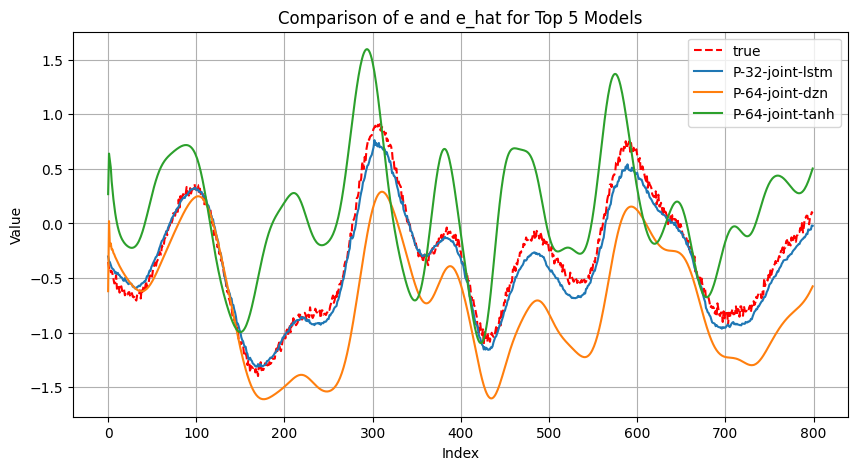

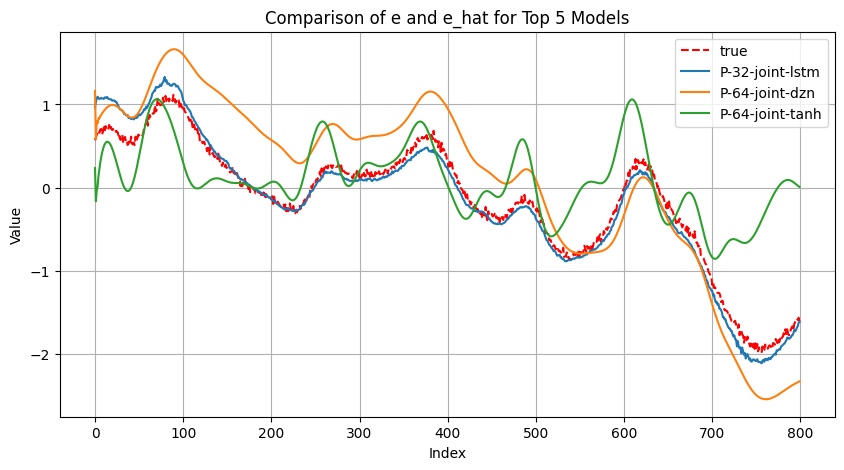

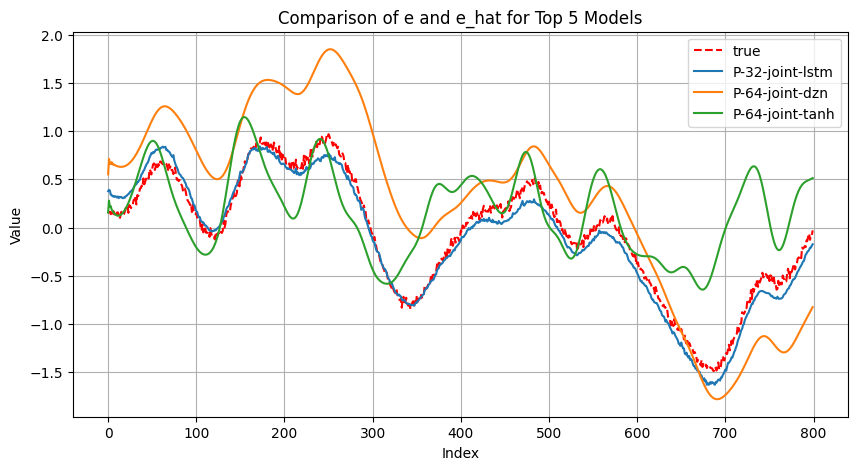

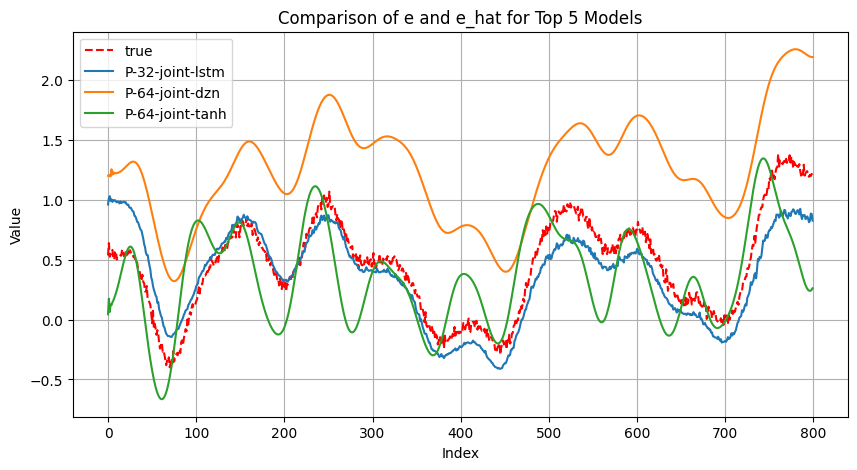

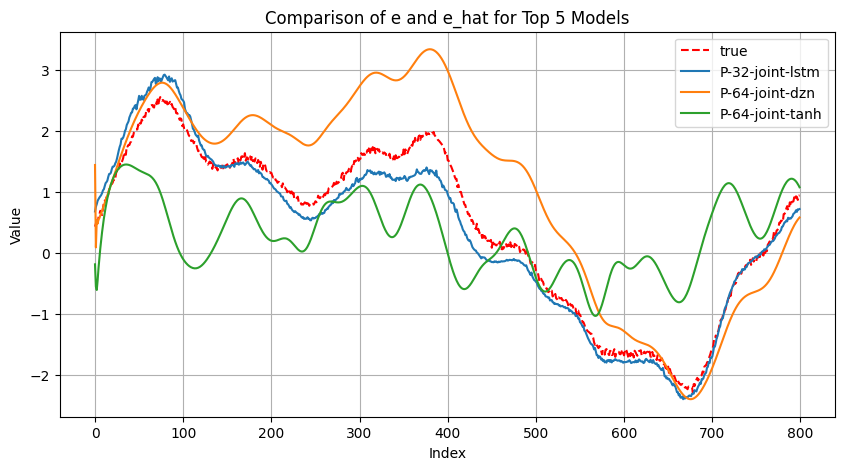

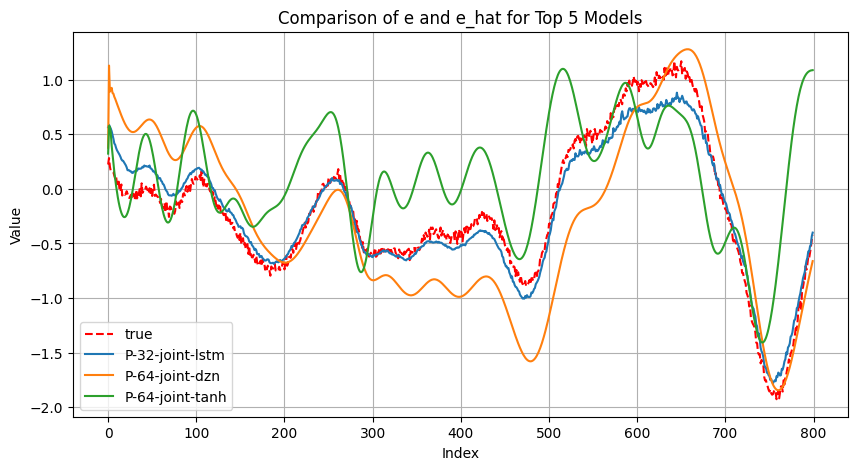

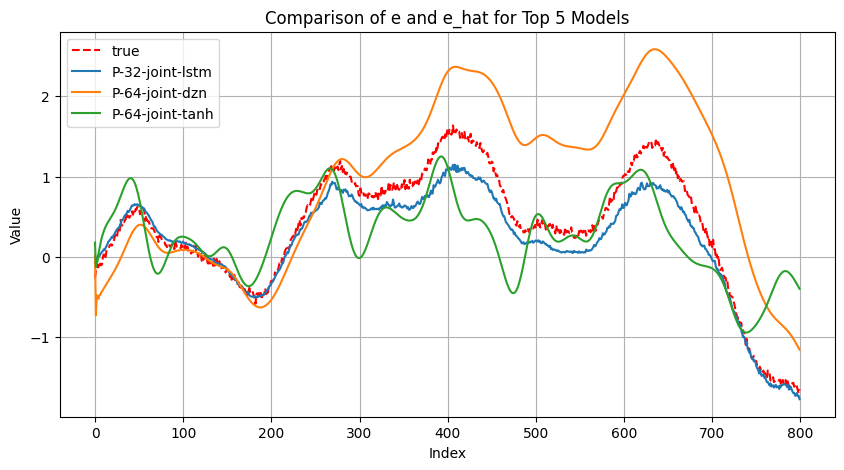

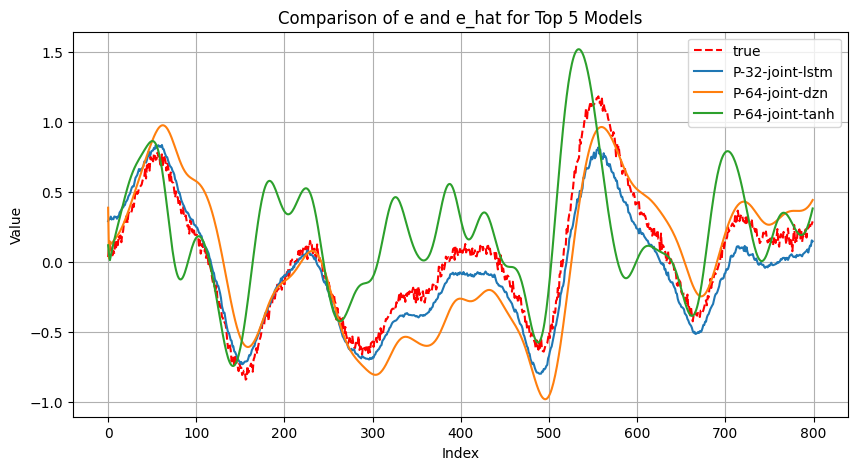

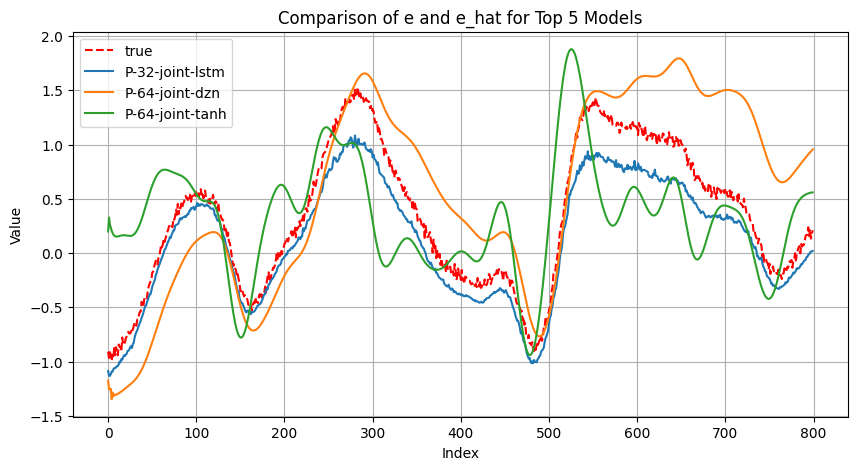

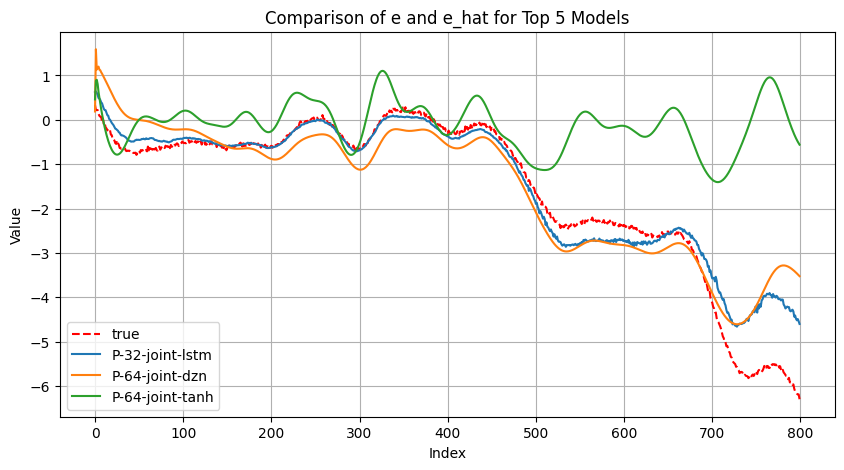

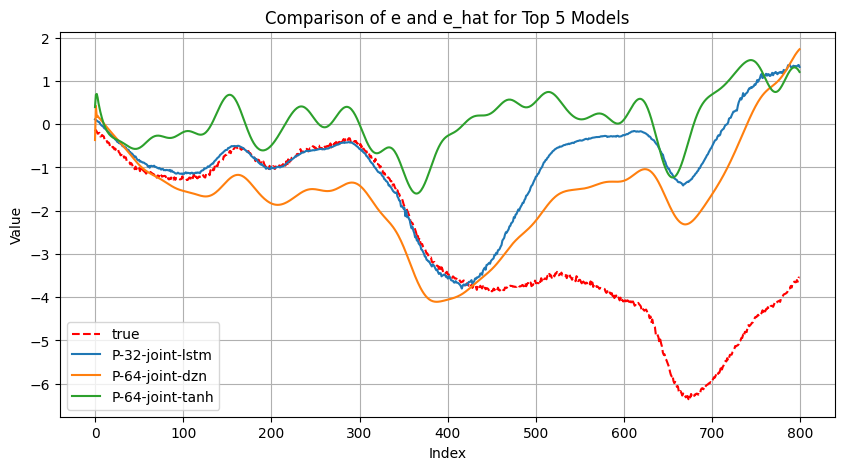

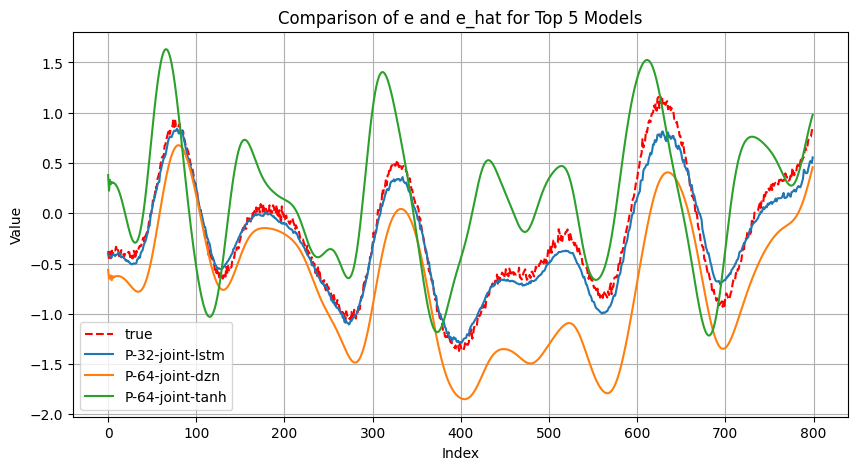

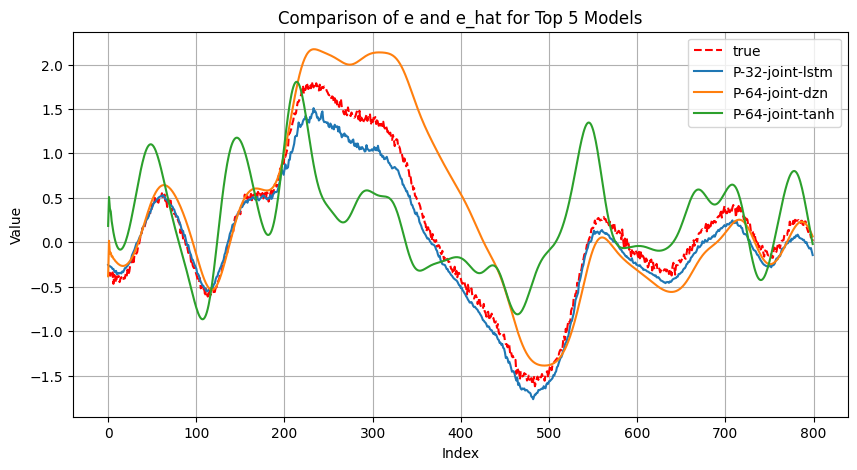

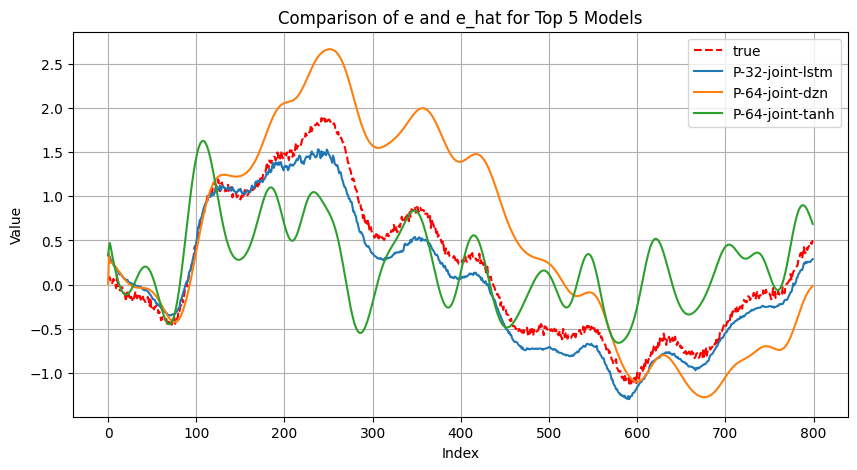

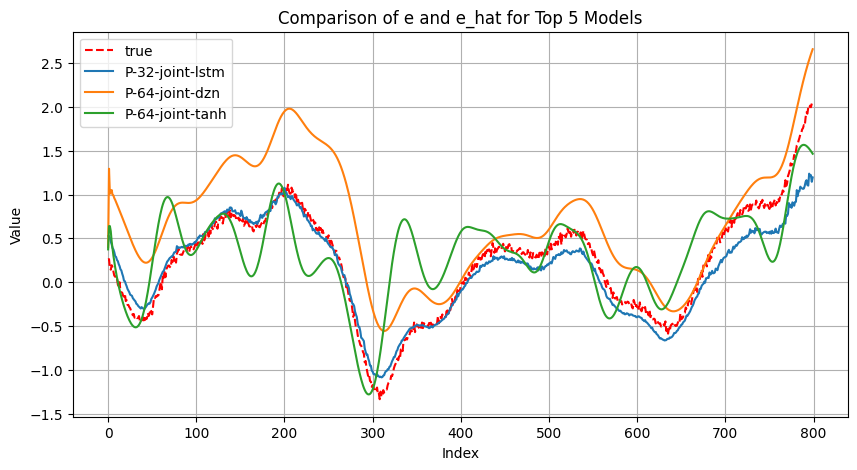

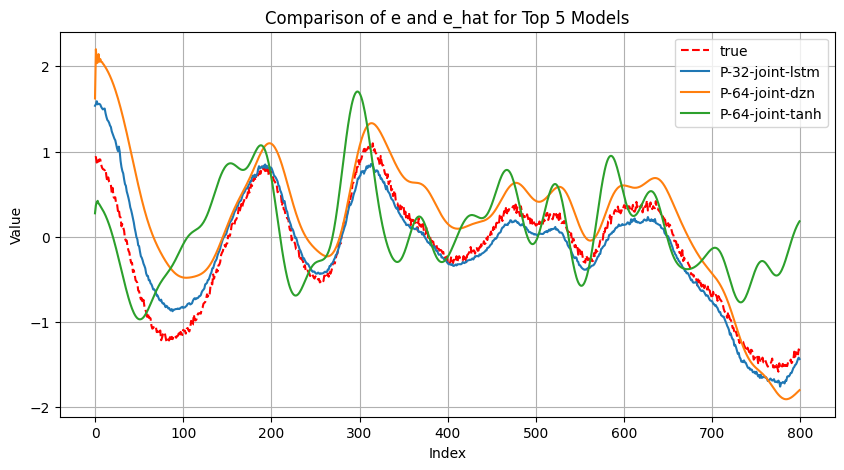

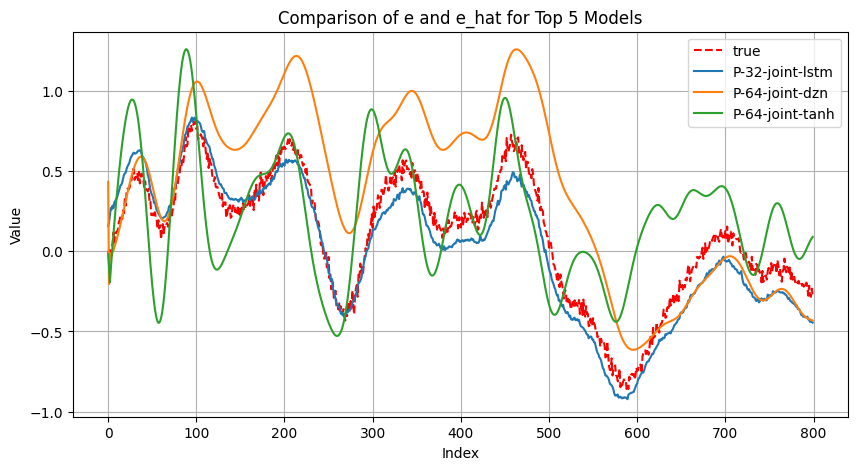

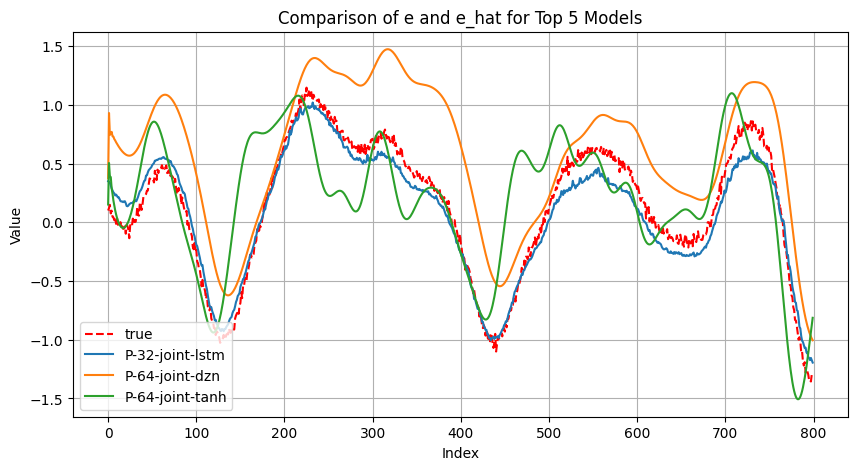

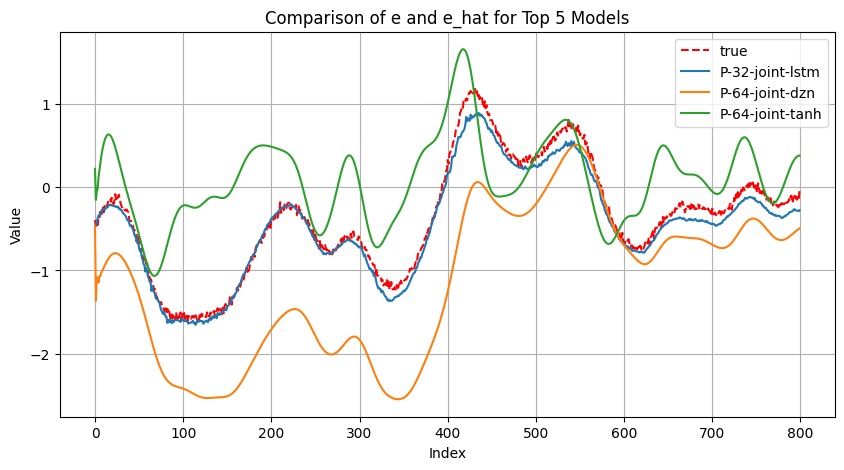

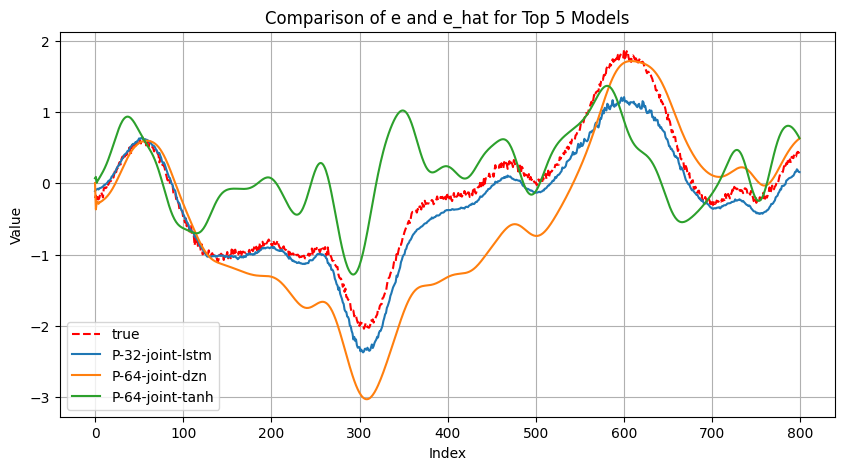

In [25]:


dataset_name = 'nonlinear-initial_state-0_M-500_T-10'
sequences_folder_name = 'seq'

# Define the row index to plot
for row_index in range(20):
# row_index = 2
# Read the "test_output.mat" file from the first subdirectory to get "e"
    first_folder = model_folders[0]
    mat_file_path = os.path.join(first_folder,sequences_folder_name, f'test_output-{dataset_name}.mat')
    if os.path.isfile(mat_file_path):
        mat_data = scipy.io.loadmat(mat_file_path)
        e = mat_data['e']
    else:
        print(f"File not found in folder: {first_folder}")

    # Plot the first row of "e" (true values)
    # fig, ax = plt.subplots(figsize=(10, 5))
    # ax.plot(e[row_index], 'r--', label='true')

    # # Iterate through each subdirectory to read "e_hat" and plot it
    # for folder in model_folders:
    #     mat_file_path = os.path.join(folder,sequences_folder_name, f'test_output-{dataset_name}.mat')
    #     if os.path.isfile(mat_file_path):
    #         mat_data = scipy.io.loadmat(mat_file_path)
    #         e_hat = mat_data['e_hat']
    #         subfolder_name = os.path.basename(folder)
    #         ax.plot(e_hat[row_index], label=subfolder_name)
    #     else:
    #         print(f"File not found in folder: {folder}")

    # # Add labels and legend
    # ax.set_xlabel('Index')
    # ax.set_ylabel('Value')
    # ax.set_title('Comparison of e and e_hat')
    # ax.grid()
    # ax.legend()

    import tikzplotlib
    # Save the figure using tikzplotlib
    # tikzplotlib.save(os.path.join(embedding_dir, "comparison_plot.tex"))


    # Get the first 5 subfolders from the sorted df_results dataframe
    top_5_folders = df_results.head(3)['Model']

    # Plot the first row of "e" (true values)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(e[row_index], 'r--', label='true')

    # Iterate through the top 5 subfolders to read "e_hat" and plot it
    for subfolder in top_5_folders:
        folder_path = os.path.join(result_folder, subfolder)
        mat_file_path = os.path.join(folder_path,sequences_folder_name, f'test_output-{dataset_name}.mat')
        if os.path.isfile(mat_file_path):
            mat_data = scipy.io.loadmat(mat_file_path)
            e_hat = mat_data['e_hat']
            ax.plot(e_hat[row_index], label=subfolder)
        else:
            print(f"File not found in folder: {folder_path}")

    # Add labels and legend
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    ax.set_title('Comparison of e and e_hat for Top 5 Models')
    ax.grid()
    ax.legend()

    # fig,ax = plt.subplots(figsize=(10, 5))
    # ax.plot(d[row_index])
    # ax.grid()
    # ax.set_title('input d')


    # tikzplotlib.save(os.path.join(embedding_dir, f"top_5_comparison_plot-{row_index}.tex"))